## Libraries

In [51]:
# basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# model
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import shap

## Data Manipulation

In [40]:
mode_allcat = pd.read_csv("mode_allcat.csv")
mode_ordinal = pd.read_csv("mode_ordinal.csv")
nan_allcat = pd.read_csv("nan_allcat.csv")

In [14]:
# Split train test data
mode_allcat_train, mode_allcat_test = train_test_split(mode_allcat, test_size=0.2, random_state=7)
mode_ordinal_train, mode_ordinal_test = train_test_split(mode_ordinal, test_size=0.2, random_state=7)
nan_allcat_train, nan_allcat_test = train_test_split(nan_allcat, test_size=0.2, random_state=7)

## Modeling

### Decision Tree

Data 1 best param: DecisionTreeClassifier(max_depth=10, min_samples_leaf=12, min_samples_split=40,
                       random_state=7, splitter='random')
Model AUC (with data 1) = 0.742497171615705


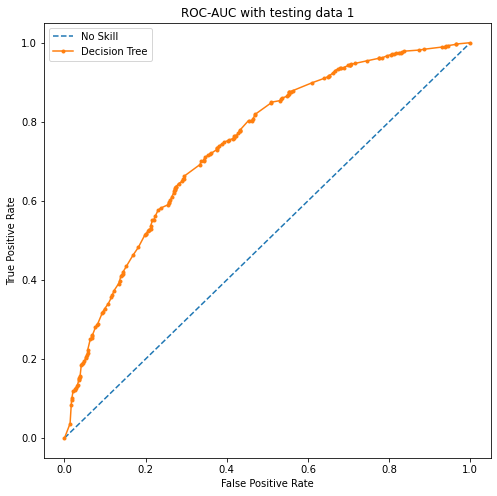

Data 2 best param: DecisionTreeClassifier(max_depth=10, min_samples_leaf=12, min_samples_split=40,
                       random_state=7)
Model AUC (with data 2) = 0.740622257228234


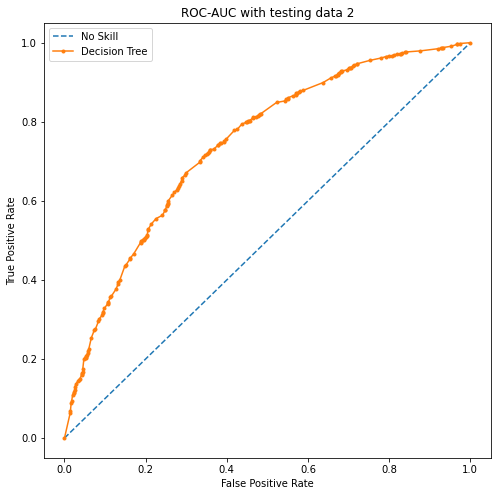

In [47]:
# param to search
dtc = {
    "criterion":["gini","entropy","log_loss"],
    "splitter":["best","random"],
    "max_depth":[12,10,8,7,6,5,4,3],
    "min_samples_split":[2,5,8,10,20,40],
    "min_samples_leaf":[3,5,7,10,12,15],
    "max_leaf_nodes":[None],
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    tree = GridSearchCV(DecisionTreeClassifier(random_state=7), dtc, n_jobs=1, scoring='roc_auc', cv=4)
    
    tree.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {tree.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = tree.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

### Random Forest

In [ ]:
# param to search
rfc = {
    "n_estimators":[100,300,500],
    "criterion":["gini","entropy","log_loss"],
    "max_depth":[12,10,8,7,6,5,4,3],
    "min_samples_split":[2,5,8,10,20,40],
    "min_samples_leaf":[3,5,7,10,12,15],
    "max_leaf_nodes":[None],
    "bootstrap":[True,False]
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    rf = GridSearchCV(RandomForestClassifier(random_state=7), rfc, n_jobs=1, scoring='roc_auc', cv=4)
    
    rf.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {tree.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = rf.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

### XGBoost

In [ ]:
# param to search
xgb_param = {
    "booster":["gbtree","dart"],
    "eta":[.1,.2,.3,.4,.5,.6,.7,.8,.9],
    
    "gamma":[0,1,5,10,50,100],
    "max_depth":[12,10,8,7,6,5,4,3],
    
    "lambda":[0,.1,.3,.5,.7,.9,1],
    "alpha":[0,.1,.3,.5,.7,.9,1],
    "tree_method":['auto',"approx","hist"]
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    xgb = GridSearchCV(XGBClassifier(random_state=7), xgb_param, n_jobs=1, scoring='roc_auc', cv=4)
    
    xgb.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {tree.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = xgb.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

## Neural Network

In [ ]:
# param to search
nn_param = {
    "hidden_layer_sizes":[150,100,50],
    "activation":["identity", "logistic", "tanh", "relu"],
    "solver":["lbfgs","sgd","adam"],
    
    "alpha":[0.0001,.001,.01,.1,.3,.5,.7],
    
    "learning_rate":["constant", "invscaling", "adaptive"], #Only used when solver='sgd'
    "learning_rate_init": [.001,.01,.1]#Only used when solver='sgd' or 'adam'
    
    "max_iter":[200,500],
    "shuffle":[True,False],  #Only used when solver=’sgd’ or ‘adam’.
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    nn = GridSearchCV(MLPClassifier(random_state=7), nn_param, n_jobs=1, scoring='roc_auc', cv=4)
    
    nn.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {tree.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = nn.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()